In [1]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [68]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project.git/sy/work/common/common.py'>

In [4]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 500

In [5]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
project_name = "unsw"

In [6]:
# %run datasets/covertype.ipynb
# %run datasets/kdd.ipynb
# %run datasets/cicids.ipynb
# %run datasets/thyroid.ipynb
%run datasets/unsw.ipynb

In [7]:
# Should already be one hot encoded and label encoded
# all_df, main_labels, config = get_processed_covtype_df()
# all_df, main_labels, config = get_processed_kdd_df()
# all_df, main_labels, config = get_processed_cicids_df()
# all_df, main_labels, config = get_processed_thyroid_df()
all_df, main_labels, config = get_processed_unsw_df()

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    Normal
Name: attack_cat, dtype: category
Categories (10, object): ['Analysis', 'Backdoor', 'DoS', 'Exploits', ..., 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']
TARGET_DICT {0: 'Analysis', 1: 'Backdoor', 2: 'DoS', 3: 'Exploits', 4: 'Fuzzers', 5: 'Generic', 6: 'Normal', 7: 'Reconnaissance', 8: 'Shellcode', 9: 'Worms'}
NORMAL_TARGET 6
main_labels Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload',
       'sloss', 'dloss',
       ...
       'service_ssl', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_PAR', 'state_REQ', 'state_RST', 'state_URN', 'state_no'],
      dtype='object', length=187)


,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.121478,6,4,258,172,74.087486,14158.942383,8495.365234,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.649902,14,38,734,42014,78.473373,8395.112305,503571.312500,2,17,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.623129,8,16,364,13186,14.170161,1572.271851,60929.230469,1,6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.681642,12,12,628,770,13.677108,2740.178955,3358.622070,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.449454,10,6,534,268,33.373825,8561.499023,3987.059814,2,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_df.shape

(175341, 187)

In [10]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [9]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [10]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(140272, 186) (35069, 186) (140272,) (35069,)


In [11]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no,attack_cat
96203,0.518188,10,8,794,1158,32.806625,1.103846e+04,15654.549805,2,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6
58960,0.000009,2,0,200,0,111111.109375,8.888889e+07,0.000000,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
65069,0.919013,18,12,6070,678,31.555592,4.990571e+04,5414.504395,5,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6
64133,1.003319,10,10,762,4220,18.937147,5.469845e+03,30283.488281,2,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
111445,0.000005,2,0,200,0,200000.000000,1.600000e+08,0.000000,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3


In [12]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [17]:
# Loop through each cover type and create a dataset
benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    a, b = 0, 0  # Track abnormal and benign sample counts
    
    # Open the output file for writing
    output_path = os.path.join(OUTPUT_FOLDER, f"{name}.csv")
    with open(output_path, "w") as ths:
        ths.write(','.join(main_labels) + "\n")
        
        # Calculate the number of benign samples based on the fixed ratio
        abnormal_count = abnormal_type_dict[label]
        benign_num = max(min(int(abnormal_count * benign_ratio), benign), min_benign_samples)
        # print(f'Creating {name}.csv with {benign_num} benign samples and {abnormal_count} abnormal samples.')

        # Collect normal (benign) rows and abnormal rows
        benign_rows = []
        abnormal_rows = []

        # Read all_data.csv line by line and collect rows
        with open("all_data.csv", "r") as file:
            for i, line in enumerate(file):
                if i == 0:
                    continue  # Skip the header row
                k = line.strip().split(",")  # Strip newline and split the line
                
                # Collect normal rows
                if int(k[target_index]) == NORMAL_TARGET:
                    benign_rows.append(line)
                
                # Collect abnormal rows that match the current label
                elif int(k[target_index]) == label:
                    abnormal_rows.append(line)

        # Randomly sample benign rows
        if len(benign_rows) > benign_num:
            benign_rows = random.sample(benign_rows, benign_num)
        else:
            benign_rows = random.sample(benign_rows, len(benign_rows))  # Shuffle if fewer than required

        # Concatenate benign and abnormal rows
        combined_rows = benign_rows + abnormal_rows
        
        # Shuffle the combined rows
        random.shuffle(combined_rows)

        # Write the shuffled rows to the output file
        for row in combined_rows:
            ths.write(row)

        # Print number of rows written
        b = len(benign_rows)
        a = len(abnormal_rows)
        print(f"{name}.csv created with {a + b} rows. ({b} benign and {a} abnormal rows)")

print("All datasets created successfully!")

abnormal_type_dict {6: 56000, 5: 40000, 3: 33393, 4: 18184, 2: 12264, 7: 10491, 0: 2000, 1: 1746, 8: 1133, 9: 130}
Analysis.csv created with 6000 rows. (4000 benign and 2000 abnormal rows)
Backdoor.csv created with 5238 rows. (3492 benign and 1746 abnormal rows)
DoS.csv created with 36792 rows. (24528 benign and 12264 abnormal rows)
Exploits.csv created with 89393 rows. (56000 benign and 33393 abnormal rows)
Fuzzers.csv created with 54552 rows. (36368 benign and 18184 abnormal rows)
Generic.csv created with 96000 rows. (56000 benign and 40000 abnormal rows)
Reconnaissance.csv created with 31473 rows. (20982 benign and 10491 abnormal rows)
Shellcode.csv created with 3399 rows. (2266 benign and 1133 abnormal rows)
Worms.csv created with 390 rows. (260 benign and 130 abnormal rows)
All datasets created successfully!


In [18]:
len(main_labels)

187

In [ ]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
SVMs = {}
ensembles = {}

process_csv_with_args = partial(
        common.process_csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler 
    )

with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_csv_with_args, csv_files))

# Collect results from the futures
for label, important_features, svm, impor_bars in results:
    feature_importances[label] = important_features
    SVMs[label] = svm
    # ensembles[label] = ensemble

    # Show feature importance
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

csv_files ['Exploits.csv', 'Analysis.csv', 'Worms.csv', 'Shellcode.csv', 'Fuzzers.csv', 'DoS.csv', 'Reconnaissance.csv', 'Generic.csv', 'Backdoor.csv']
Processing CSV file:Processing CSV file:Processing CSV file:Processing CSV file:Processing CSV file:Processing CSV file:Processing CSV file:Processing CSV file:Processing CSV file:         Analysis.csvShellcode.csvExploits.csvDoS.csvWorms.csvFuzzers.csvReconnaissance.csvGeneric.csvBackdoor.csv










In [64]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# # Define the parameter grid to search
# param_distributions = {
#     'n_estimators': [100, 200, 300, 400, 500],               # Number of trees
#     'max_depth': [None, 10, 20, 30, 40, 50],                 # Tree depth
#     'min_samples_split': [2, 5, 10],                         # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],                           # Minimum samples at a leaf
#     'max_features': ['auto', 'sqrt', 'log2'],                # Number of features to consider at each split
#     'bootstrap': [True, False]                               # Use bootstrap samples or not
# }

# # Perform random search with cross-validation
# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_distributions, 
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    cv=3,        # 3-fold cross-validation
#                                    random_state=42, 
#                                    n_jobs=-1)   # Use all cores

# Fit the model
# random_search.fit(X_train_df, y_train_df)
rf.fit(X_train_df, y_train_df)

# Best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [6 5 3 ... 6 6 4]
Total operation time: =  3.9136481285095215 seconds


Multiclass Classification Evaluation
Confusion Matrix:
[[   54     3    42   248     2     0    44     0     0     0]
 [    2    37    42   267     4     0     2     4     2     0]
 [    3     3   314  1971    33     0    23    16     7     0]
 [    3     0   509  5922   101     6    89   126    16     0]
 [    5     3    52   315  2594     6   566     3    26     0]
 [    0     1    23   137    16  7896     4     0     0     2]
 [    4     0     1    96   842     0 10203    15     7     1]
 [    0     2    73   437     3     0     2  1581     0     0]
 [    0     0     6    26    62     2    38     2    97     0]
 [    0     0     0    23     1     0     0     0     0     1]]


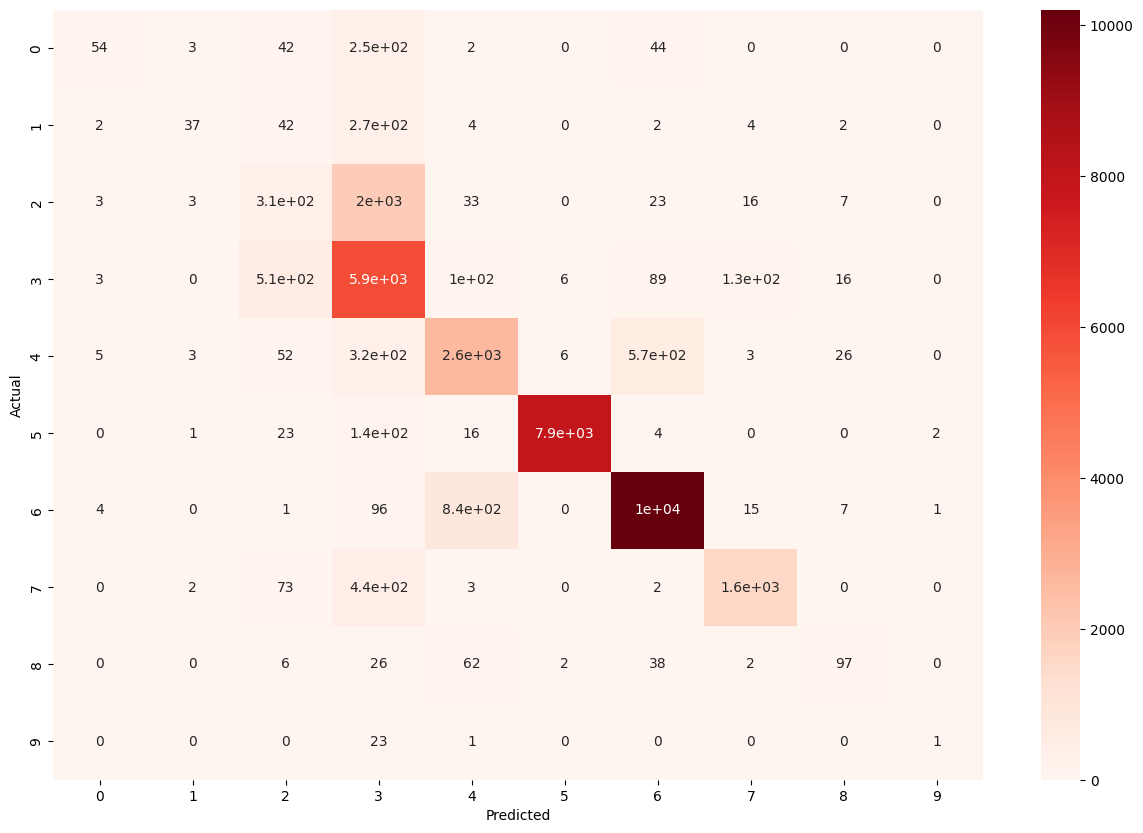


Classification Report:
{'0': {'precision': 0.7605633802816901, 'recall': 0.13740458015267176, 'f1-score': 0.2327586206896552, 'support': 393.0}, '1': {'precision': 0.7551020408163265, 'recall': 0.10277777777777777, 'f1-score': 0.18092909535452323, 'support': 360.0}, '2': {'precision': 0.295668549905838, 'recall': 0.13248945147679325, 'f1-score': 0.18298368298368298, 'support': 2370.0}, '3': {'precision': 0.6271976276212666, 'recall': 0.8744831659775546, 'f1-score': 0.7304798322437399, 'support': 6772.0}, '4': {'precision': 0.7091306724986332, 'recall': 0.726610644257703, 'f1-score': 0.7177642501383508, 'support': 3570.0}, '5': {'precision': 0.9982300884955753, 'recall': 0.9773486817675455, 'f1-score': 0.9876790293326662, 'support': 8079.0}, '6': {'precision': 0.9299972655181843, 'recall': 0.9135106097233414, 'f1-score': 0.9216802168021679, 'support': 11169.0}, '7': {'precision': 0.9049799656554093, 'recall': 0.7535748331744518, 'f1-score': 0.822366710013004, 'support': 2098.0}, '8': {

Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.81836
f1-score_avg,0.80461
precision_avg,0.81419
recall_avg,0.81836


In [65]:
pn = "pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [66]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    
    if test_predictions[i] == NORMAL_TARGET:
        # class_probabilities = {}
        
        # # Test the normal data point with all anomaly models
        # for class_label, svm_model in SVMs.items():
        #     # Select features for the SVM
        #     selected_features = feature_importances[class_label]
        #     test_instance_selected_df = test_instance_df[selected_features]
        #     proba = svm_model.predict_proba(test_instance_selected_df)
            
        #     # We take the probability of class 0 (anomaly class)
        #     anomaly_proba = proba[0][0]
        #     class_probabilities[class_label] = anomaly_proba

        # # Get the class with the highest probability
        # most_probable_class = max(class_probabilities, key=class_probabilities.get)
        
        # # If the highest probability class has a probability greater than a threshold (e.g., 0.5), classify it as anomaly
        # if class_probabilities[most_probable_class] > 0.5:
        #     svm_predictions.append((0, INV_TARGET_DICT[most_probable_class], y_test_df.iloc[i]))
        # else:
            # Otherwise, classify it as normal
        svm_predictions.append((1, NORMAL_TARGET, y_test_df.iloc[i]))
    else:
        # if test_predictions[i] == NORMAL_TARGET:
        #     svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        #     continue
        predicted_label = TARGET_DICT[test_predictions[i]]
        # print('predicted_label', predicted_label)
        selected_features = feature_importances[predicted_label]
        # print('selected_features', selected_features)
        svm_model = SVMs[predicted_label]
        
        # Select features for the SVM
        test_instance_selected_df = test_instance_df[selected_features]
        svm_prediction = svm_model.predict(test_instance_selected_df)
        # print('svm prediction: ', svm_prediction[0], 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
        svm_predictions.append((svm_prediction[0], INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ", time.time() - seconds, "seconds")

Total operation time: =  35.84372019767761 seconds


SVM Evaluation (overall)
Confusion Matrix:
[[    0     3    35    10     0     0   345     0     0     0]
 [    0     1    38    16     1     0   300     4     0     0]
 [    0     0   183   262     4     0  1901    15     5     0]
 [    0     0   382  3438    35     1  2781   126     9     0]
 [    0     0    39    58   911     1  2532     3    26     0]
 [    0     0    15    84     9  7845   126     0     0     0]
 [    0     0     0    83   313     0 10750    15     7     1]
 [    0     0    61   121     0     0   335  1581     0     0]
 [    0     0     5    19    20     1    97     2    89     0]
 [    0     0     0    21     1     0     2     0     0     1]]


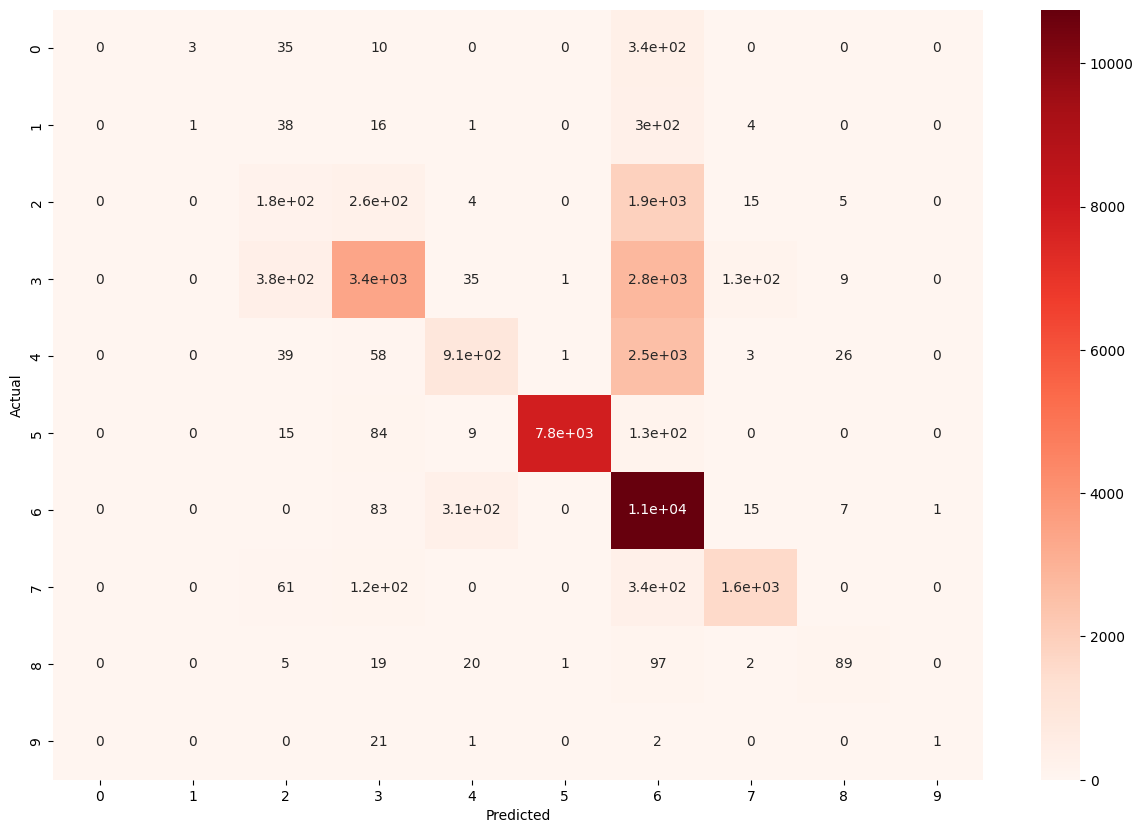


Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 393.0}, '1': {'precision': 0.25, 'recall': 0.002777777777777778, 'f1-score': 0.005494505494505495, 'support': 360.0}, '2': {'precision': 0.24142480211081793, 'recall': 0.07721518987341772, 'f1-score': 0.1170076726342711, 'support': 2370.0}, '3': {'precision': 0.8360894941634242, 'recall': 0.5076786769049025, 'f1-score': 0.6317530319735392, 'support': 6772.0}, '4': {'precision': 0.7040185471406492, 'recall': 0.25518207282913163, 'f1-score': 0.3745888157894737, 'support': 3570.0}, '5': {'precision': 0.9996177370030581, 'recall': 0.9710360193093205, 'f1-score': 0.9851196082124695, 'support': 8079.0}, '6': {'precision': 0.5608012937555428, 'recall': 0.9624854508013251, 'f1-score': 0.708682180763399, 'support': 11169.0}, '7': {'precision': 0.9054982817869416, 'recall': 0.7535748331744518, 'f1-score': 0.8225806451612903, 'support': 2098.0}, '8': {'precision': 0.6544117647058824, 'recall': 0.3819742489

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.70715
f1-score_avg,0.67321
precision_avg,0.71977
recall_avg,0.70715


In [67]:
# Evaluate SVM on all test data
pn = "pipeline-" + project_name
wandb.init(project=pn, name="final")

# Modify the list and extract the second element in one step
final_svm_predictions = [(lambda t: (t[0], NORMAL_TARGET, t[2]) if t[0] == 1 else t)(t)[1] for t in svm_predictions]
final_svm_predictions_df = pd.DataFrame(final_svm_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_svm_predictions_df, heading='SVM Evaluation (overall)')
wandb.finish()